In [1]:

import sympy as sm
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# device = 'cpu'
sympyTorchmodules = {'sin': torch.sin, 'cos': torch.cos}


### 1D Poisson PDE Class

\begin{align}
u_{xx} &= f(x), \hspace{1.3cm} x \in \Omega \\
u(x) &= g(x), \hspace{1.3cm} x \in \partial \Omega
\end{align}

Where: 

\begin{align}
    f(x) &= -a^{2}\pi^{2}\sin(a\pi x), \hspace{0.2cm} x \in [0,1] \\
    g(x) &= 0, \hspace{2.3cm} x = 0,1
\end{align}

In [2]:
class Poisson1D:

    def __init__(self, a=None):

        self.setup_equations()
        self.setup_residuals()

        if a != None:
            self.a = 1

    def setup_equations(self, f_eqn=None, g_eqn=None):
        ### Setup

        # Variables/Coefficients
        a   = sm.symbols('a'); 

        # PDE States
        x        = sm.symbols('x')      # domain
        xbc = sm.symbols('x1:3')   # partial domain for boundary condition

        u   = sm.symbols('u', cls=sm.Function)(x)
        ux  = u.diff(x)
        uxx = ux.diff(x)

        # Forcing/External/Boundary/Initial condition functions
        f   = sm.symbols('f', cls=sm.Function)(x)
        g   = sm.symbols('g', cls=sm.Function)(x)

        # Set up PDE_eqn
        self.PDE_eqn = sm.Eq(uxx,f)

        # Set up boundary condition
        # bc_eq1 = sm.Piecewise((u, sm.Eq(x, xbc[0])),  (u, sm.Eq(x, xbc[1])), (0, True))
        # bc_eq2 = sm.Piecewise((g, sm.Eq(x, xbc[0])),  (g, sm.Eq(x, xbc[1])), (0, True))
        self.BC_eqn  = sm.Eq(u, g)

        # For reuse in class
        self.x   = x 
        self.xbc = xbc
        self.U = [u, ux, uxx]
        self.f = f 
        self.g = g 

    def setup_residuals(self):
        pde_residual = self.PDE_eqn.lhs - self.PDE_eqn.rhs
        bc_residual  = self.BC_eqn.lhs - self.BC_eqn.rhs

        self.pde_residual = sm.lambdify([self.x, self.U, self.f], pde_residual, modules=sympyTorchmodules)
        self.bc_residual  = sm.lambdify([self.x, self.U, self.g], bc_residual,  modules=sympyTorchmodules)        

##### Define exact, source and boundary condition functions

In [3]:
def f_u_exact(a,x):
    """ 
    Exact solution
    """
    u_exact = torch.sin(a*torch.pi*x)
    u_exact.to(device)

    return u_exact

def f_x(a, x):
    """
    Source/Forcing function
    """
    fx = -(a**2)*(torch.pi**2)*torch.sin(a*torch.pi*x)
       
    return fx

def g_x(x, xb):
    """
    Boundary condition
    """
    
    ub = torch.zeros(x.size())

    xb1_idx = torch.where(x == xb[0])[0]
    xb2_idx = torch.where(x == xb[1])[0]

    ub[xb1_idx] = 0
    ub[xb2_idx] = 0

    return ub

#### PINN Class

In [4]:
class PINN(nn.Module):
    def __init__(self, input_size, output_size, neurons, PDE):
        super(PINN, self).__init__()

        # Define layers of network
        self.layer1     = nn.Linear(input_size, neurons)
        self.layer2     = nn.Linear(neurons, output_size)

        self.layers = [self.layer1, self.layer2]

        self.activation = nn.Tanh()      

        # import and initialize PDE
        if hasattr(PDE,'pde_residual'):
            self.pde_residual = PDE.pde_residual
        if hasattr(PDE, 'bc_residual'):
            self.bc_residual = PDE.bc_residual
        if hasattr(PDE, 'ic_residual'):
            self.ic_residual = PDE.ic_residual

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_normal_(module.weight.data)            
            if module.bias is not None:
                module.bias.data.zero_()

    def forward(self, x):

        for layer in self.layers[:-1]:
            x = layer(x)
            x = self.activation(x)

        x = self.layers[-1](x)

        return x
    
    def backward(self, X, U, f=None, g=None, h=None):

        if X.shape[1] == 2:
            xr = X[0,:].view(-1,1)
            xb = X[0,:].view(-1,1)
        else:
            xr = xb = X

        if len(U.shape) == 3:
            U_x = U[0].T
            U_b = U[1].T
        else:
            U_x = U.T
            U_b = U.T

        if hasattr(self, 'pde_residual') and f != None:
            residual        = self.pde_residual(xr, U_x, f).T
            self.pde_loss   = torch.mean(residual**2)
        
            loss = self.pde_loss

        if hasattr(self, 'bc_residual') and g !=None:
            residual        = self.bc_residual(xb, U_b, g).T
            self.bc_loss    = torch.mean(residual**2)
        
            loss += self.bc_loss       

        if hasattr(self, 'ic_residual') and h != None:
            X_ic            = 0
            residual        = self.ic_residual(X,  U, h).T
            self.ic_loss    = torch.mean(residual**2)
            loss           += self.ic_loss    

        self.loss = loss

        self.loss.backward()

    def compute_NTK(self):

        



In [5]:
from torch.utils.data import DataLoader

In [6]:
## Setup PDE Equation
a   = 1
PDE = Poisson1D(a)

# Define PDE domain
X_0,X_N = 0.,1.
X_bc  = [X_0, X_N]
# dx  = 0.002; # N   = int((X_N - X_0)/dx) 

N  = 500
Xr = torch.linspace(X_0, X_N, N, dtype=torch.float32, requires_grad=True).view(-1,1).to(device); 
Xb = torch.randint(0, 2, (N,1), dtype=torch.float32, requires_grad=True).to(device)

X  = torch.hstack((Xr, Xb))

In [7]:
## Setup PINN parameters

Nr      = 100
Nb      = 100
XTrain  = DataLoader(X, Nb, shuffle=True)


size          = len(XTrain.dataset)
learning_rate = 1e-5
epochs        = int(10e3)

loss_fn   = nn.MSELoss()
optimizer = optim.SGD

input_size  = 1
output_size = 1
neurons     = 100
net         = PINN(input_size, output_size, neurons, PDE)

optimizer = optim.SGD(net.parameters(), learning_rate)
# optimizer = optim.Adam(net.parameters(), learning_rate)


In [8]:

### TRAIN LOOP
train_losses = []

for epoch in range(epochs+1):
    net.train()
    net.to(device)

    for i, x in enumerate(XTrain):

        xr = x[0,:].view(-1,1).to(device); xb = x[1,:].view(-1,1).to(device)

        # Set the gradients to zero
        optimizer.zero_grad()

        ### INTERIOR DOMAIN
        # make prediction w.r.t. interior points
        u_hat_x   = net(xr)

        # determine gradients w.r.t interior points
        ux_hat_x  = torch.autograd.grad(u_hat_x,  xr,  grad_outputs=torch.ones_like(u_hat_x),  retain_graph=True ,create_graph=True)[0]
        uxx_hat_x = torch.autograd.grad(ux_hat_x, xr,  grad_outputs=torch.ones_like(ux_hat_x), create_graph=True)[0]
        U_x       = torch.hstack([u_hat_x, ux_hat_x, uxx_hat_x])

        # Compute forcing/source function
        fx = f_x(a, xr).T.to(device)


        ### BOUNDARY DOMAIN
        u_hat_xb    = net(xb)
        # determine gradients w.r.t boundary points
        ux_hat_xb   = torch.autograd.grad(u_hat_xb,  xb,  grad_outputs=torch.ones_like(u_hat_xb),  retain_graph=True ,create_graph=True)[0]
        uxx_hat_xb  = torch.autograd.grad(ux_hat_xb, xb,  grad_outputs=torch.ones_like(ux_hat_xb), create_graph=True)[0]
        U_xb        = torch.hstack([u_hat_xb, ux_hat_xb, uxx_hat_xb])
        # compute boundary condition
        gx = g_x(xb, X_bc).T.to(device)

        U = torch.stack((U_x, U_xb), dim=0)

        # residual = net.pde_residual(xr, U_x.T, fx).T

        # loss = torch.mean(residual**2)

        # net.loss = loss

        # loss.backward()

        net.backward(x, U, fx, gx)

        train_losses.append(net.loss.item())

        optimizer.step()
           
        # if i % Nb == 0 and epoch % 100 == 0:
        #     loss, current = net.loss.item(), (i + 1) * len(x)
        #     print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    if epoch % 100 == 0 or epoch == epochs - 1: 
        print(f"Epoch: {epoch}     loss: {train_losses[-1]:5f}")


Epoch: 0     loss: 19.606123
Epoch: 100     loss: 23.918852
Epoch: 200     loss: 20.243004
Epoch: 300     loss: 48.711094
Epoch: 400     loss: 5.654016
Epoch: 500     loss: 0.016617
Epoch: 600     loss: 45.659145
Epoch: 700     loss: 27.812616
Epoch: 800     loss: 5.807205
Epoch: 900     loss: 8.425043
Epoch: 1000     loss: 48.331184
Epoch: 1100     loss: 30.498520
Epoch: 1200     loss: 48.548214
Epoch: 1300     loss: 46.816914
Epoch: 1400     loss: 27.782223
Epoch: 1500     loss: 6.409551
Epoch: 1600     loss: 3.637266
Epoch: 1700     loss: 10.564672
Epoch: 1800     loss: 13.192702
Epoch: 1900     loss: 28.370987
Epoch: 2000     loss: 2.726539
Epoch: 2100     loss: 5.404237
Epoch: 2200     loss: 1.190823
Epoch: 2300     loss: 34.208153
Epoch: 2400     loss: 0.838621
Epoch: 2500     loss: 18.921368
Epoch: 2600     loss: 1.813237
Epoch: 2700     loss: 0.047792
Epoch: 2800     loss: 1.008689
Epoch: 2900     loss: 14.555729
Epoch: 3000     loss: 14.802182
Epoch: 3100     loss: 48.131966
E

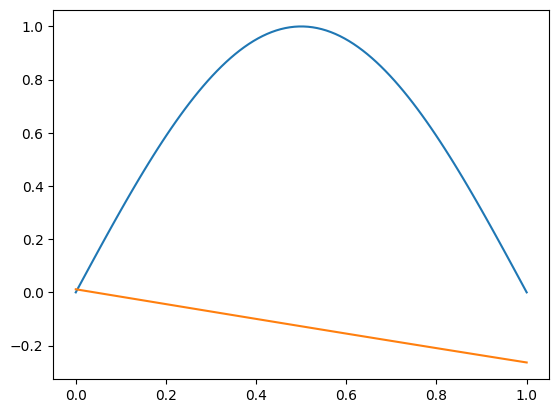

In [ ]:
xplot = torch.linspace(X_0, X_N, N, requires_grad=True).view(-1,1).to(device);

# compute exact solution
u_exact = f_u_exact(a, xplot)
u_pred  = net(xplot)

xplot   = xplot.cpu().detach().numpy()
u_exact = u_exact.cpu().detach().numpy()
u_pred  = u_pred.cpu().detach().numpy()

# predict
plt.plot(xplot, u_exact)
plt.plot(xplot, u_pred)

plt.show()